GW170817_GalacticNS.ipynb -- reweight GW170817 posterior to Galactic NS population

In [1]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

! pip install corner
import corner

In [2]:
# import sodapop

! git clone https://github.com/landryp/sodapop.git # only need to run this once
import sys
sys.path.insert(0,'/content/sodapop')
import sodapop.priors as prior
import sodapop.populations as pop

Cloning into 'sodapop'...
remote: Enumerating objects: 682, done.
remote: Counting objects: 100% (682/682), done.
remote: Compressing objects: 100% (468/468), done.
remote: Total 682 (delta 357), reused 527 (delta 211), pack-reused 0
Receiving objects: 100% (682/682), 2.75 MiB | 3.30 MiB/s, done.
Resolving deltas: 100% (357/357), done.


In [3]:
# get gw170817 posterior samples

public_dcc_url= 'https://dcc.ligo.org/public/0150/P1800061/011/'
!curl -O {public_dcc_url}"high_spin_PhenomPNRT_posterior_samples.dat.gz"

data = pd.read_table('high_spin_PhenomPNRT_posterior_samples.dat.gz', delim_whitespace=True)
pnames = data.columns.values
print(pnames)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  971k  100  971k    0     0   479k      0  0:00:02  0:00:02 --:--:--  479k
['costheta_jn' 'luminosity_distance_Mpc' 'm1_detector_frame_Msun'
 'm2_detector_frame_Msun' 'lambda1' 'lambda2' 'spin1' 'spin2' 'costilt1'
 'costilt2']


In [4]:
# convert detector frame masses to source frame in gw170817 samples -- note that the paper actually fixed z = 0.0099

H0 = 67.4 # planck 2018 H0 in km/s/Mpc Used to account of change of masses from the red shift. Use this for GW190425. 
c = 2.998e5 # speed of light in km/s

data['m1'] = data.apply(lambda row : row['m1_detector_frame_Msun'] / (1+H0 * row['luminosity_distance_Mpc']/c) , axis = 1)
data['m2'] = data.apply(lambda row : row['m2_detector_frame_Msun'] / (1+H0 * row['luminosity_distance_Mpc']/c) , axis = 1)

In [5]:
# define transformed observables

def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

data['mchirp'] = data.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
data['q']= data.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
data['chi_eff']= data.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
data['lambdatilde'] = data.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

In [6]:
# define spins priors -- these will eventually be moved into sodapop

def allowed_psr(chi):
	
  chimin = 0.
  chimax = 0.7

  if np.isscalar(chi): chi = np.array([chi])
  else: chi = np.array(chi)
  z = np.zeros(len(chi))
	
  p = np.full(len(chi),1./(chimax-chimin))
	
  return np.where((chi > chimax) | (chi < chimin), z, p)

def slow_psr(chi):
	
  chimin = 0.
  chimax = 0.05

  if np.isscalar(chi): chi = np.array([chi])
  else: chi = np.array(chi)
  z = np.zeros(len(chi))
	
  p = np.full(len(chi),1./(chimax-chimin))
	
  return np.where((chi > chimax) | (chi < chimin), z, p)
 
def fast_psr(chi):
	
  chimin = 0.05
  chimax = 0.7

  if np.isscalar(chi): chi = np.array([chi])
  else: chi = np.array(chi)
  z = np.zeros(len(chi))
	
  p = np.full(len(chi),1./(chimax-chimin))
	
  return np.where((chi > chimax) | (chi < chimin), z, p)
 
def slowfast_chi1chi2(chi1,chi2):

  if np.isscalar(chi1): chi1 = np.array([chi1])
  else: chi1 = np.array(chi1)
  if np.isscalar(chi2): chi2 = np.array([chi2])
  else: chi2 = np.array(chi2)
  z = np.zeros(len(chi1))

  p = 0.5*slow_psr(chi1)*fast_psr(chi2) + 0.5*slow_psr(chi2)*fast_psr(chi1)
	
  return np.where((chi1 > 1.) | (chi2 > 1.), z, p)

def allowed_chi1chi2(chi1,chi2):

  if np.isscalar(chi1): chi1 = np.array([chi1])
  else: chi1 = np.array(chi1)
  if np.isscalar(chi2): chi2 = np.array([chi2])
  else: chi2 = np.array(chi2)
  z = np.zeros(len(chi1))

  p = allowed_psr(chi1)*allowed_psr(chi2)
	
  return np.where((chi1 > 1.) | (chi2 > 1.), z, p)

In [7]:
# define tidal deformability priors -- these will eventually be moved into sodapop

def allowed_lambda1lambda2(lambda1,lambda2):

  if np.isscalar(lambda1): lambda1 = np.array([lambda1])
  else: lambda1 = np.array(lambda1)
  if np.isscalar(lambda2): lambda2 = np.array([lambda2])
  else: lambda2 = np.array(lambda2)
  z = np.zeros(len(lambda1))

  p = 1.
	
  return np.where((lambda1 > lambda2), z, p) 

In [8]:
# define new population-informed prior and reweight gw170817 posterior samples to it

old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det_quad_dL') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('bimodcut_m1m2') # function of m1, m2, population parameters
pop_params = [1.34, 0.07, 1.80, 0.21, 0.65, 0.9, 2.12]

#data = data.truncate(after=1000)

# weight samples based on galactic mass prior
data['massweight']  = data.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],pop_params)*allowed_chi1chi2(row['spin1'],row['spin2'])*allowed_lambda1lambda2(row['lambda1'],row['lambda2'])  
                            /  old_prior_mass(row['m1'],row['m2'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data['massweight']=[d[0] for d in data['massweight']/data['massweight'].sum() * data['massweight'].size]

In [9]:
# store the unweighted and reweighted samples in a dataframe

data0 = data.copy()
data0['massweight'] = np.ones(len(data0['massweight']))

data['prior'] = 'Galactic'
data0['prior'] = 'LVK'

df = pd.concat([data, data0]).reset_index()

In [10]:
# draw samples from the original prior distribution, so that we can plot it -- this functionality will eventually be moved into sodapop

num_prior = 1000

prior_data0 = data0.truncate(after=num_prior-1).copy()
massA = np.random.uniform(0.5,7.7,num_prior)
massB = np.random.uniform(0.5,7.7,num_prior)
prior_data0['m1_detector_frame_Msun'] = [max(A,B) for A,B in zip(massA,massB)]
prior_data0['m2_detector_frame_Msun'] = [min(A,B) for A,B in zip(massA,massB)]
dist = np.random.uniform(0.1,1000.,len(data['massweight']))
prior_data0['luminosity_distance_Mpc'] = np.random.choice(dist,num_prior,True,[d**2 for d in dist]/np.sum([d**2 for d in dist]))
prior_data0['spin1'] = np.random.uniform(0.,0.89,num_prior)
prior_data0['spin2'] = np.random.uniform(0.,0.89,num_prior)
prior_data0['lambda1'] = np.random.uniform(0.,5000.,num_prior)
prior_data0['lambda2'] = np.random.uniform(0.,5000.,num_prior)
prior_data0['costilt1'] = np.random.uniform(-1.,1.,num_prior)
prior_data0['costilt2'] = np.random.uniform(-1.,1.,num_prior)

prior_data0['m1'] = prior_data0.apply(lambda row : row['m1_detector_frame_Msun'] / (1+H0 * row['luminosity_distance_Mpc']/c) , axis = 1)
prior_data0['m2'] = prior_data0.apply(lambda row : row['m2_detector_frame_Msun'] / (1+H0 * row['luminosity_distance_Mpc']/c) , axis = 1)

prior_data0['mchirp'] = prior_data0.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
prior_data0['q']= prior_data0.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
prior_data0['chi_eff']= prior_data0.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
prior_data0['lambdatilde'] = prior_data0.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

In [11]:
# draw samples from the population-informed prior distribution -- this functionality will eventually be moved into sodapop

prior_data = prior_data0.truncate(after=num_prior-1).copy()
massA = np.random.uniform(0.9,2.2,len(data['massweight']))
massB = np.random.uniform(0.9,2.2,len(data['massweight']))
mass1 = [max(A,B) for A,B in zip(massA,massB)]
mass2 = [min(A,B) for A,B in zip(massA,massB)]
idxs = np.random.choice(range(len(mass1)),num_prior,True,new_prior_mass(mass1,mass2,pop_params)/new_prior_mass(mass1,mass2,pop_params).sum())
prior_data['m1'] = np.array([mass1[idx] for idx in idxs])
prior_data['m2'] = np.array([mass2[idx] for idx in idxs])
dist = np.random.uniform(0.1,1000.,len(data['massweight']))
prior_data['luminosity_distance_Mpc'] = np.random.choice(dist,num_prior,True,[d**2 for d in dist]/np.sum([d**2 for d in dist]))
spin1 = np.random.uniform(0.,0.89,len(data['massweight']))
spin2 = np.random.uniform(0.,0.89,len(data['massweight']))
idxs = np.random.choice(range(len(spin1)),num_prior,True,allowed_chi1chi2(spin1,spin2)/allowed_chi1chi2(spin1,spin2).sum())
prior_data['spin1'] = [spin1[idx] for idx in idxs]
prior_data['spin2'] = [spin2[idx] for idx in idxs]
lambdaA = np.random.uniform(0.,5000.,num_prior)
lambdaB = np.random.uniform(0.,5000.,num_prior)
prior_data['lambda1'] = [min(A,B) for A,B in zip(lambdaA,lambdaB)]
prior_data['lambda2'] = [max(A,B) for A,B in zip(lambdaA,lambdaB)]
prior_data['costilt1'] = np.random.uniform(-1.,1.,num_prior)
prior_data['costilt2'] = np.random.uniform(-1.,1.,num_prior)

prior_data['mchirp'] = prior_data.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
prior_data['q']= prior_data.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
prior_data['chi_eff']= prior_data.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
prior_data['lambdatilde'] = prior_data.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

In [12]:
# store the original and population-informed prior samples in a dataframe

prior_data['massweight'] = np.ones(num_prior)
prior_data0['massweight'] = np.ones(num_prior)

prior_data['prior'] = 'Galactic (prior)'
prior_data0['prior'] = 'LVK (prior)'

prior_df = pd.concat([prior_data, prior_data0]).reset_index()

all_df = pd.concat([df, prior_df]).reset_index()

In [13]:
# now let's add some uncertainty to the population model, reweight to many realizations of the popuation-informed prior, and average

num_pops = 100

mu1s = np.random.normal(1.34,0.03,num_pops)
mu2s = np.random.normal(1.80,0.17,num_pops)
sigma1s = np.random.normal(0.07,0.02,num_pops)
sigma2s = np.random.normal(0.21,0.16,num_pops)
ws = np.random.normal(0.65,0.12,num_pops)
mmins = np.random.uniform(0.9,0.9,num_pops)
mmaxs = np.random.normal(2.12,0.11,num_pops)

ii = 0
for pop_params in zip(mu1s,sigma1s,mu2s,sigma2s,ws,mmins,mmaxs):

  pop_data = data0.sample(1000)

  pop_data['massweight'] = pop_data.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],pop_params)*allowed_chi1chi2(row['spin1'],row['spin2'])*allowed_lambda1lambda2(row['lambda1'],row['lambda2'])  
                            /  old_prior_mass(row['m1'],row['m2'],row['luminosity_distance_Mpc']) 
                            , axis = 1)

  pop_data['massweight']=[d[0] for d in pop_data['massweight']/pop_data['massweight'].sum() * pop_data['massweight'].size]

  pop_data['prior'] = 'Galactic {0}'.format(ii)
  if ii == 0: popmarg_data = pop_data
  else: popmarg_data = popmarg_data.append(pop_data)

  ii += 1

/content/sodapop/sodapop/populations.py:97: RuntimeWarning: invalid value encountered in true_divide
  p = w*gaussian(m,(mu1,sigma1))/norm1 + (1.-w)*gaussian(m,(mu2,sigma2))/norm2
/content/sodapop/sodapop/populations.py:97: RuntimeWarning: divide by zero encountered in true_divide
  p = w*gaussian(m,(mu1,sigma1))/norm1 + (1.-w)*gaussian(m,(mu2,sigma2))/norm2


In [14]:
# store the population-marginalized samples in the dataframe with the others

marg_df = pd.concat([data,data0,prior_data,prior_data0,popmarg_data]).reset_index()

In [32]:
# specify some global plot settings

sns.set_palette([sns.color_palette("Paired")[1],sns.color_palette("Paired")[3],'k',sns.color_palette("Paired")[8]])
palette = {"Galactic (prior)": 'gray', 'LVK (prior)': sns.color_palette()[1], 'Galactic': sns.color_palette()[0], 'LVK': sns.color_palette()[1]}
for jj in range(ii): palette['Galactic {0}'.format(jj)] = sns.color_palette()[0]

replacements = {'m1': r'$m_1 \,[M_\odot]$', 'm2': r'$m_2 \,[M_\odot]$', 'spin1': r'$\chi_1$', 'spin2': r'$\chi_2$', 'lambda1': r'$\Lambda_1$', 'lambda2': r'$\Lambda_2$', 'mchirp': r'$\mathcal{M} \,[M_\odot]$', 'q': r'$q$', 'chi_eff': r'$\chi_\mathrm{eff}$', 'lambdatilde': r'$\tilde{\Lambda}$'}
limits = {'m1': (1.2,2.0), 'm2': (0.7,1.5), 'spin1': (0.,1.), 'spin2': (0.,1.), 'lambda1': (0.,2000.), 'lambda2': (0.,2000.), 'mchirp': (1.1,1.2), 'q': (0.3,1.), 'chi_eff': (-0.2,0.2), 'lambdatilde': (0.,2000.)}

lower_priors = ["Galactic (prior)"]
diag_priors = ['LVK (prior)','Galactic (prior)']
posts = ['LVK','Galactic']
traces = ["Galactic {0}".format(jj) for jj in range(ii)]

handles = {}
for key in palette.keys():
  if '(prior)' in key: handles[key] = mlines.Line2D([], [], color=palette[key], ls=':', label=key)
  else: handles[key] = mlines.Line2D([], [], color=palette[key], label=key)

In [33]:
def fancy_corner(df,vars,hue_col='prior',wt_col='massweight',lower_priors=lower_priors,diag_priors=diag_priors,prior_alpha=0.5,posts=posts,post_levels=[0.1,0.5],traces=traces,trace_levels=[0.1],trace_alpha=0.1,handles=handles,palette=palette,replacements=replacements,limits=limits):

  fig = sns.PairGrid(df, vars=vars, corner=True, diag_sharey=False)
  fig.map_lower(sns.kdeplot, data=df.query(hue_col+' in @lower_priors'), weights=df[wt_col], levels=20, cmap='gray_r', fill=True, alpha=prior_alpha, antialiased=True)
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=diag_priors, palette=palette, fill=False, ls=':', alpha=1, common_norm=False, weights=df[wt_col])
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=posts, palette=palette, fill=False, common_norm=False, weights=df[wt_col])
  fig.map_diag(sns.kdeplot, data=df, hue=hue_col, hue_order=traces, palette=palette, fill=False, alpha=trace_alpha, common_norm=False, weights=df[wt_col])
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=posts, palette=palette, levels=post_levels, weights=df[wt_col])
  fig.map_lower(sns.kdeplot, data=df, hue=hue_col, hue_order=traces, palette=palette, levels=trace_levels, alpha=trace_alpha, weights=df[wt_col])
  fig.add_legend(label_order=[*posts,*diag_priors],legend_data=handles)

  for i in range(len(vars)):
    for j in range(i+1):
        xlabel = vars[j]
        ylabel = vars[i]
        if xlabel in replacements.keys():
            fig.axes[i][j].set_xlabel(replacements[xlabel])
            fig.axes[i][j].set_xlim(*limits[xlabel])
        if ylabel in replacements.keys():
            fig.axes[i][j].set_ylabel(replacements[ylabel])
            fig.axes[i][j].set_ylim(*limits[ylabel])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density 

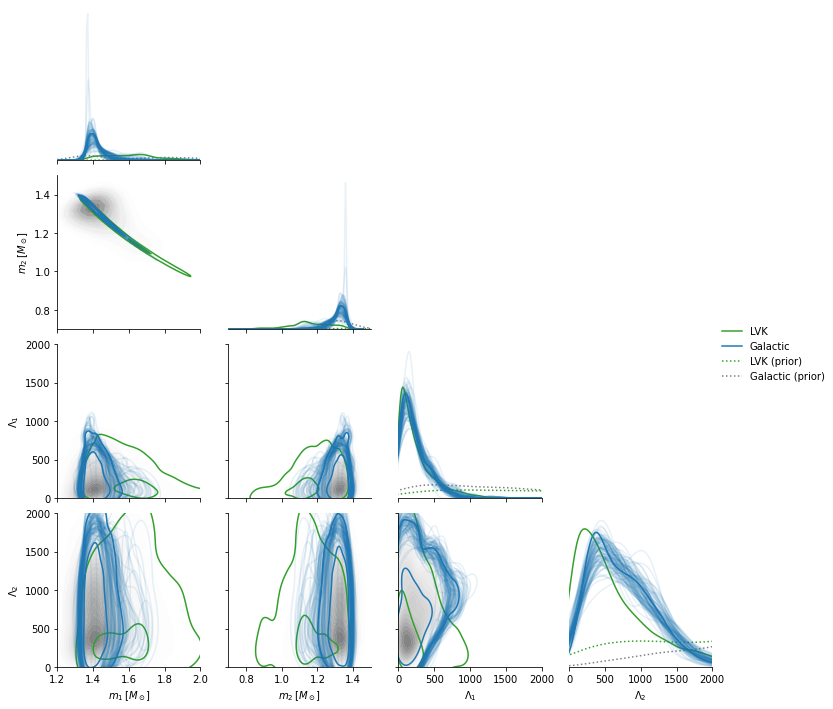

In [34]:
# make a corner plot of the tidal sector

fancy_corner(marg_df,["m1","m2",'lambda1','lambda2'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density

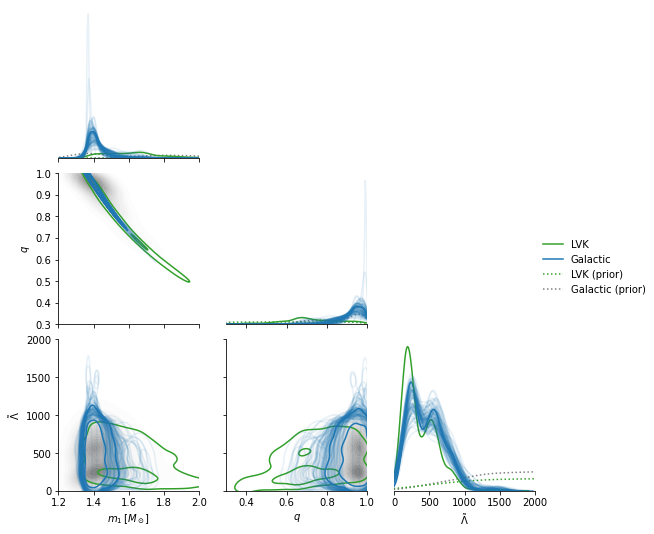

In [35]:
# make a corner plot of the tidal sector in transformed variables

fancy_corner(marg_df,["m1","q",'lambdatilde'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density 

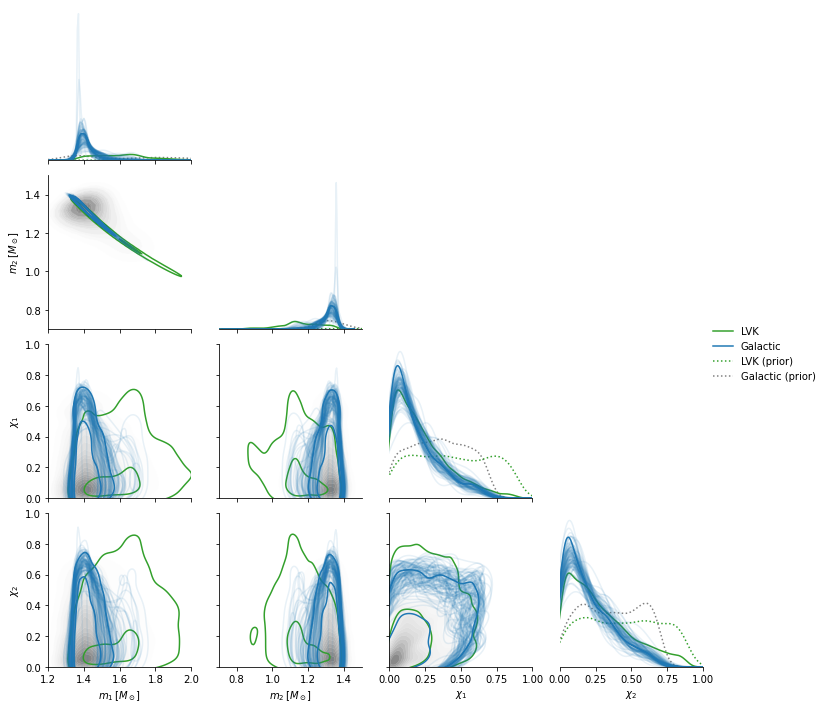

In [36]:
# make a corner plot of the spin sector

fancy_corner(marg_df,["m1","m2",'spin1','spin2'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density 

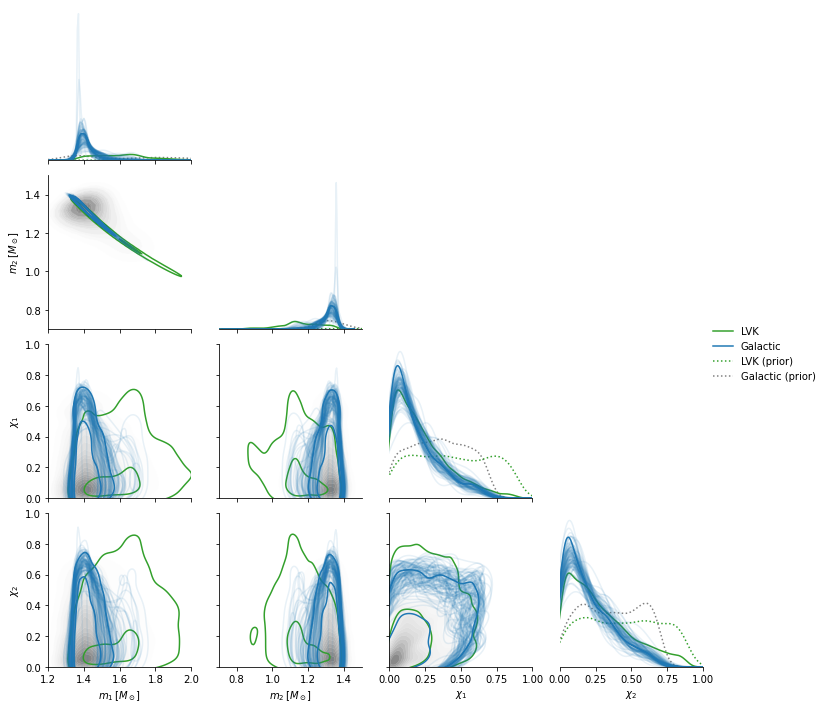

In [37]:
# make a corner plot of the spin sector in transformed variables

fancy_corner(marg_df,["m1","m2",'spin1','spin2'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density e

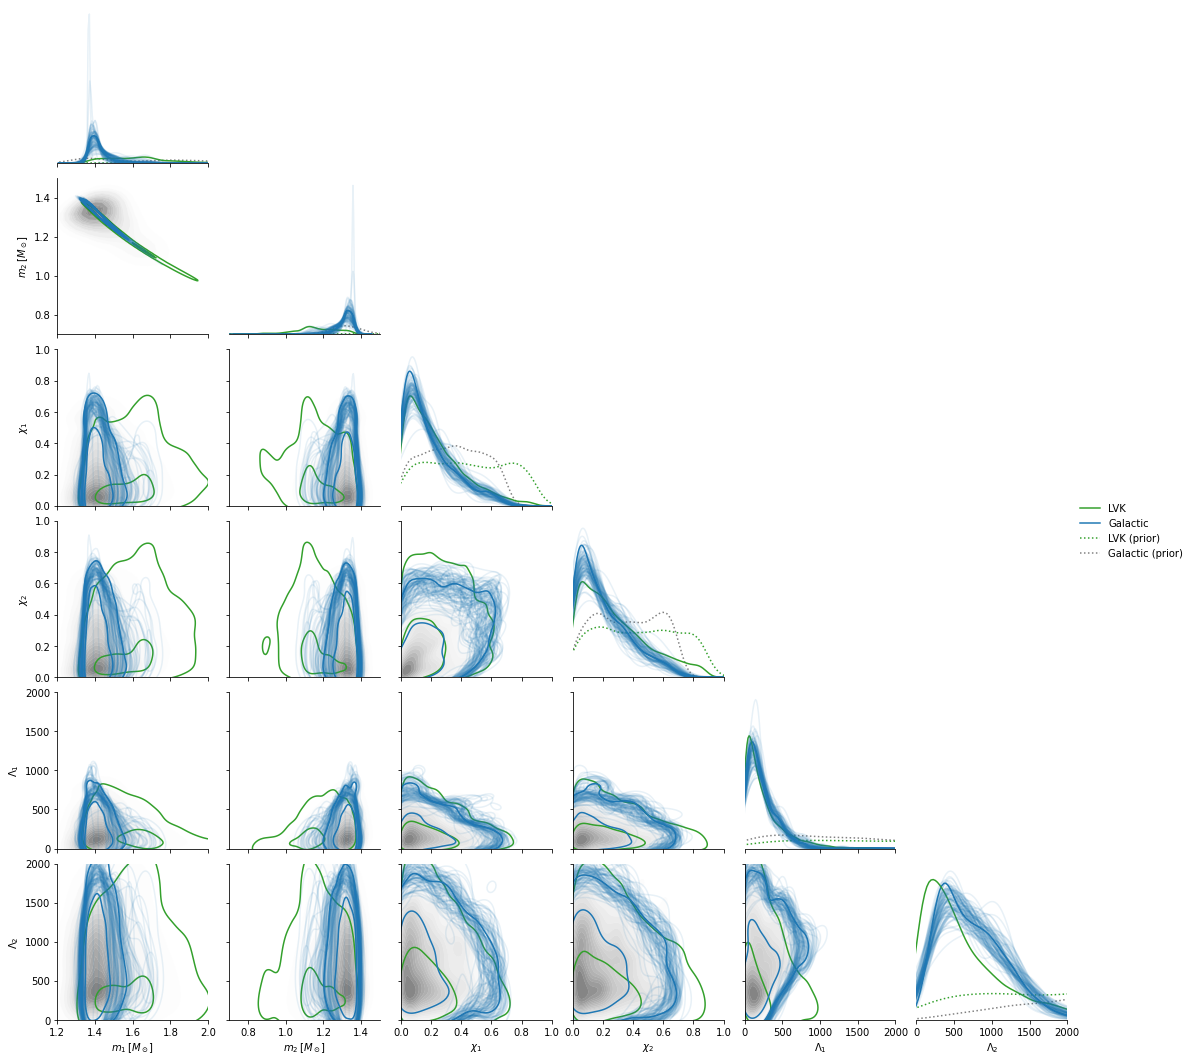

In [38]:
# make a corner plot of all the observables

fancy_corner(marg_df,["m1","m2",'spin1','spin2','lambda1','lambda2'])